In [1]:
import math
import random
import matplotlib.pyplot as plt

class Value:
    def __init__(self, data, label = ""):
        self.value = data
        self.grad = 0.0
        self.children = []
        self.setGrad = lambda : None
        self.label = label


    # Add function

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)            
        out = Value(self.value + other.value)
        
        def setGrad():
            self.grad += out.grad
            other.grad += out.grad
            
        out.setGrad = setGrad
        out.children.extend([self, other])
        return out

    def __radd__(self, other):
        return self.__add__(other)


    # Mull function

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)            
        out = Value(self.value * other.value)
        
        def setGrad():
            self.grad += out.grad * other.value
            other.grad += out.grad * self.value
            
        out.setGrad = setGrad
        out.children.extend([self, other])
        return out

    def __rmul__(self, other):
        return self.__mul__(other)


    # Tanh function

    def tanh(self):
        x = self.value
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t)
    
        def setGrad():
            self.grad += (1 - t**2) * out.grad

        out.setGrad = setGrad
        out.children.extend([self])
        return out

    # Pow operation

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.value**other)

        def setGrad():
            self.grad += other * (self.value ** (other - 1)) * out.grad

        out.setGrad = setGrad
        out.children.extend([self])

        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other):
        return self.__sub__(other)
    
    def __repr__(self):
        return f"{self.label} {self.value} : {self.grad}"

    def _backprop(self):
        self.setGrad()
        for c in self.children:
            c._backprop()

    def backprop(self):
        self.grad = 1.0
        self._backprop()

    def Zero(self):
        self.grad = 0.0
        for c in self.children:
            c.Zero()


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for i in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        out = self.b
        for xi, wi in zip(x, self.w):
            out += xi * wi
        out = out.tanh()
        return out

    def params(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for i in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def params(self):
        return [p for neuron in self.neurons for p in neuron.params()]


class Net:
    def __init__(self, sizes):
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def params(self):
        return [p for layer in self.layers for p in layer.params()]

In [10]:
a = Value(-1, "a")
b = Value(1, "b")
c =  a * b
c.label = "c"
d = c.tanh()
d.label = "d"

In [11]:
print(a)
print(b)
print(c)
print(d)

a -1 : 0.0
b 1 : 0.0
c -1 : 0.0
d -0.7615941559557649 : 0.0


In [12]:
d.backprop()

back prop d
back tanh
back prop c
back mul
back prop a
back prop b


In [84]:
n = Neuron(3)
n([1.0, 2.0, 3.0])

 0.9754498860112863 : 0.0

In [3]:
# Features/Inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1.0]

N = Net([3, 4, 4, 1])
losses = []

In [4]:
for _ in range(1000):
    ypred = [N(xi) for xi in xs]
    loss = sum((ysi - ypredi)**2 for ysi, ypredi in zip(ys, ypred))
    #print(loss)
    losses.append(loss.value)

    loss.Zero()
    loss.backprop()
    
    for p in N.params():
        p.value += -0.01 * p.grad

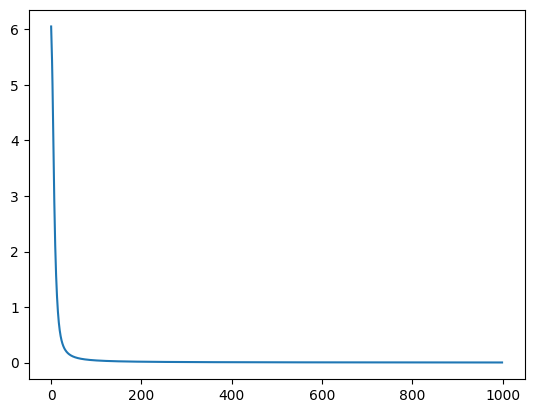

In [5]:
# Crear una gráfica de línea
plt.plot(losses)
# Mostrar la gráfica
plt.show()

In [169]:
losses[999]

0.0032560065361072277